## An exploration analysis on papers about Quantum + Machine Learning

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import warnings
warnings.filterwarnings('ignore')
from util import find_prime_authors, name_query
from util import getting_citation_by_title, getting_citation_by_arxiv_id
from pyaxv import arXiv_getter

#### Fetch data from arXiv

In [59]:
arxiv_getter = arXiv_getter()
query = ['neural network','learning','boltzmann machine','recognition']
category = ['quant-ph','cond-mat.dis-nn','cond-mat.mtrl-sci',
            'cond-mat.mes-hall','cond-mat.other','cond-mat.quant-gas',
           'cond-mat.soft','cond-mat.stat-mech','cond-mat.str-el','cond-mat.supr-con',
           'hep-th','hep-ph','hep-lat','math-ph']
df = arxiv_getter.get(query, category)

Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aneural+AND+network+AND+cat%3Aquant-ph&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aneural+AND+network+AND+cat%3Acond-mat.dis-nn&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aneural+AND+network+AND+cat%3Acond-mat.mtrl-sci&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aneural+AND+network+AND+cat%3Acond-mat.mes-hall&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aneural+AND+network+AND+cat%3Acond-mat.other&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Aneural+AND+network+AND+cat%3Acond-mat.

Fetching from http://export.arxiv.org/api/query?search_query=ti%3Arecognition+AND+cat%3Acond-mat.quant-gas&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Arecognition+AND+cat%3Acond-mat.soft&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Arecognition+AND+cat%3Acond-mat.stat-mech&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Arecognition+AND+cat%3Acond-mat.str-el&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Arecognition+AND+cat%3Acond-mat.supr-con&sortBy=lastUpdatedDate&sortOrder=descending&start=0&max_results=1000
Fetching from http://export.arxiv.org/api/query?search_query=ti%3Arecognition+AND+cat%3Ahep-th&sortBy=lastUpdatedDate&sortOrder=d

Some paper titled 'what can we learn from' are usually not related to machine learning. Remove them.

In [72]:
df = df.drop(df.index[(df['title'].apply(lambda t: 'we learn' in t.lower()))])

In [74]:
df.shape

(1647, 15)

#### Some distributions

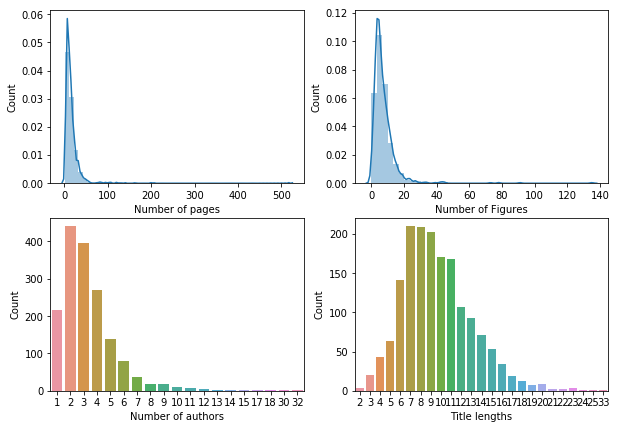

In [75]:
f, axs = plt.subplots(2,2,figsize=(10,7))

plt.subplot(2,2,1)
seaborn.distplot(df.pages[df.pages.notnull()],hist=True,bins=50)
_ = plt.xlabel('Number of pages')
_ = plt.ylabel('Count')

plt.subplot(2,2,2)
seaborn.distplot(df.figures[df.figures.notnull()],hist=True,bins=40)
#_,_,ax = plt.hist(df.figures,bins=40)
_ = plt.xlabel('Number of Figures')
_ = plt.ylabel('Count')

plt.subplot(2,2,3)
seaborn.countplot(x="num_of_authors", data=df)
#_,_,ax = plt.hist(df.num_of_authors,bins=30)
_ = plt.xlabel('Number of authors')
_ = plt.ylabel('Count')

plt.subplot(2,2,4)
seaborn.countplot(x="title_length", data=df)
_ = plt.xlabel('Title lengths')
_ = plt.ylabel('Count')

#### Let's have a look at who contributes most in this area

In [110]:
th=6
names = find_prime_authors(df, threshold=th)
print('Number of prime authors(publication > {}): {} '.format(th, len(names)))
print('total number of papers contributed by these people: ' + str(sum(names)))

Number of prime authors(publication > 6): 40 
total number of papers contributed by these people: 395


#### Visualization

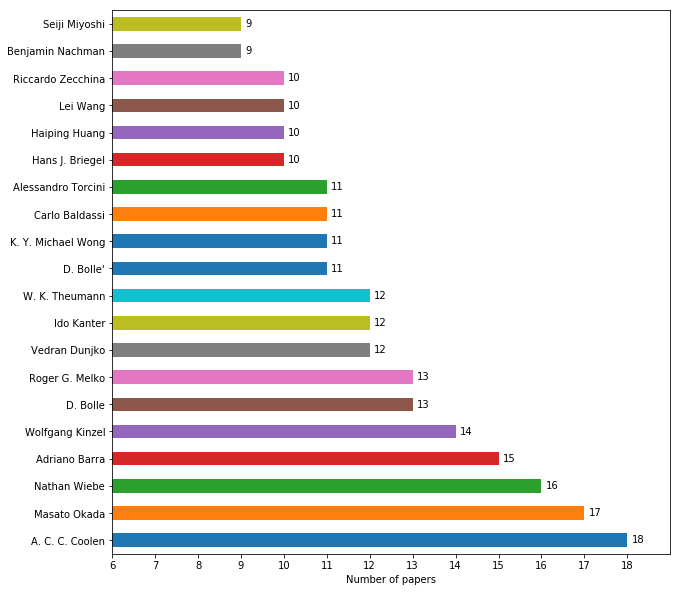

In [111]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)  
plt.xticks(list(range(5,max(names)+1)))
plt.xlim([names[20]-3,max(names)+1])
plt.xlabel('Number of papers')
_ = names[:20].plot.barh()

for i, v in enumerate(names[:20]):
    ax.text(v+0.1 , i-0.1, str(v), color='black', )

#### Let's have a look at these papers published by Nathan Wiebe, for example

In [113]:
name_query(df,'wiebe')[['arxiv_id', 'title', 'year_of_publish','month_of_publish']]

,arxiv_id,title,year_of_publish,month_of_publish
732,1807.09753v1,Magnetic-field-learning using a single electro...,2018,7
753,1611.09347v2,Quantum Machine Learning,2016,11
783,1712.07570v1,Experimental Phase Estimation Enhanced By Mach...,2017,12
790,1711.06652v1,Hardening Quantum Machine Learning Against Adv...,2017,11
818,1703.05402v1,Experimental Quantum Hamiltonian Learning,2017,3
839,1512.03145v1,Can small quantum systems learn?,2015,12
850,1412.3489v2,Quantum Deep Learning,2014,12
851,1409.1524v3,Quantum Bootstrapping via Compressed Quantum H...,2014,9
863,1401.2142v2,Quantum Algorithms for Nearest-Neighbor Method...,2014,1
868,1311.5269v2,Quantum Hamiltonian Learning Using Imperfect Q...,2013,11


When did this hype start?

Text(0, 0.5, 'Number of papers')

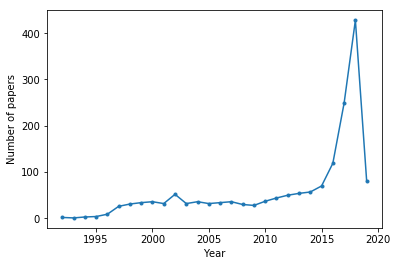

In [115]:
plt.plot(df.year_of_publish.value_counts().sort_index(),'.-')
plt.xlabel('Year')
plt.ylabel('Number of papers')

In [ ]:
citations = []
for e, arxiv_id in enumerate(list(df.arxiv_id)):
    print(e, arxiv_id)
    citations.append(getting_citation_by_arxiv_id(arxiv_id))